In [ ]:
from astropy.io import fits
import numpy as np
from astropy.table import QTable
import astropy.units as u
import astropy.utils
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.stats import lognorm
from astropy.timeseries import LombScargle
import time
from astropy.visualization import hist
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.time import Time
import functions

In [2]:
t_zr=QTable.read('t_zr_0418.ecsv')
t_zg=QTable.read('t_zg_0418.ecsv')
t_zr=t_zr[np.isnan(t_zr['LNP_SIG'])==False]
t_zg=t_zg[np.isnan(t_zg['LNP_SIG'])==False]


# select low LNP_SIG ones, (rule out popular periods in window function?)
def cut_LNP_SIG(t,period,LNP_SIG):
    #t=t[(t['period']<period[0])|(t['period']>period[1])]
    #t=t[(t['period']<period[2])|(t['period']>period[3])]
    #if len(period)>4:
        #t=t[(t['period']<period[4])|(t['period']>period[5])]
    t=t[t['LNP_SIG']<LNP_SIG]
    return t

# actually didnt do this period cut
period_cut_zr=(0.9970346508917344, 1.000477498206994)
period_cut_zg=(0.9969051801030641, 1.0158638399392756)

t_zr=cut_LNP_SIG(t_zr,period_cut_zr,0.0013169397670255696)
t_zg=cut_LNP_SIG(t_zg,period_cut_zg,0.00017317008113315558)


# cut power ratios
obj_zr=t_zr[t_zr['power']/t_zr['power_c']>=1]
obj_zg=t_zg[t_zg['power']/t_zg['power_c']>=1]

# cut CONST_CHI2
obj_zr=obj_zr[obj_zr['CONST_CHI2']>8]
obj_zg=obj_zg[obj_zg['CONST_CHI2']>3.5]

# cut close periods
obj_zr=obj_zr[np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']>1e-2]
obj_zg=obj_zg[np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']>1e-2]

obj_zr=obj_zr[(np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']<0.49)|(np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']>0.91)|(obj_zr['LNP_SIG']<1.966545715422768e-10)]
obj_zg=obj_zg[(np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']<0.49)|(np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']>0.91)|(obj_zg['LNP_SIG']<4.619621769038492e-14)]




# restore original table for ploting reasons
t_zr=QTable.read('t_zr_0418.ecsv')
t_zg=QTable.read('t_zg_0418.ecsv')

# choose only OID with highest numobs
mask=np.zeros(len(obj_zr))+1
for i,obj in enumerate(obj_zr):
    copy=t_zr[t_zr['SourceID']==obj['SourceID']]
    if len(copy)==1:
        if obj['numobs']<50:
            mask[i]=0
    if len(copy)>1:
        if obj['OID']!=copy['OID'][copy['numobs'].argmax()]:
            mask[i]=0
obj_zr=obj_zr[mask==1]


mask=np.zeros(len(obj_zg))+1
for i,obj in enumerate(obj_zg):
    copy=t_zg[t_zg['SourceID']==obj['SourceID']]
    if len(copy)==1:
        if obj['numobs']<50:
            mask[i]=0
    if len(copy)>1:
        if obj['OID']!=copy['OID'][copy['numobs'].argmax()]:
            mask[i]=0
obj_zg=obj_zg[mask==1]

In [3]:
obj_zr=QTable.read('periodic_zr_ztf.ecsv')
obj_zg=QTable.read('periodic_zg_ztf.ecsv')

In [4]:
def LNP_catalog(t_zr,t_zg):
    zr=np.array(t_zr['SourceID'])
    zg=np.array(t_zg['SourceID'])
    unique=np.unique(np.append(zg,zr))
    t = QTable([unique,np.isin(unique,zr),np.isin(unique,zg),np.full(len(unique), np.nan),np.full(len(unique), np.nan),np.empty(len(unique),'S14'),np.empty(len(unique),'S14')],names=('SourceID', 'variant in zr','variant in zg','period in zr','period in zg','upsilon class in zr','upsilon class in zg'))
    t['upsilon class in zr']='nan'
    t['upsilon class in zg']='nan'
    
    
    for obj in t_zr:
        t['period in zr'][np.where(t['SourceID']==obj['SourceID'])]=obj['period']
        t['upsilon class in zr'][np.where(t['SourceID']==obj['SourceID'])]=obj['upsilon_class']
        
    for obj in t_zg:
        t['period in zg'][np.where(t['SourceID']==obj['SourceID'])]=obj['period']
        t['upsilon class in zg'][np.where(t['SourceID']==obj['SourceID'])]=obj['upsilon_class']

    t['period in zr']*=u.day
    t['period in zg']*=u.day
    
    return t
cata=LNP_catalog(obj_zr,obj_zg)

In [5]:
obj_zr

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,LNP_SIG,period,period_c,power,power_c,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
52,zr,806203100023276,5.0806496,59.3093092,685,47.39395523071289,9.047098104866404,1.3897712328031495e-79,600.0,0.9973493234494499,0.6178420591152367,0.22277136277297624,LPV_OSARG_AGB,0.36,0.0,642.8628877500013
77,zr,806203100063307,5.0870906,59.2998095,887,320.27349853515625,40.2373047076145,5.847057797857361e-25,26.59597181848844,0.9973493234494499,0.2548123584808542,0.006184755430169186,CEPH_Other,0.55,0.0,26.601222941379365
90,zr,806203100056957,5.0836327,59.3114535,900,525.0966796875,110.81225216581812,6.002845842879131e-95,0.4994384343050958,0.9973493234494499,0.6263888583536013,0.24530401407698715,LPV_Mira_AGB_C,0.28,0.0,1928.588663250004
101,zr,806203100060469,5.0829101,59.2955233,296,46.7452507019043,9.349527189582291,6.345126163769892e-05,3.23649203126552,0.9973615362352404,0.18184803685938167,0.0059469445760456765,NonVar,0.65,1.0,0.03852201204840993
114,zr,1809211300066628,5.0784179,59.3140615,53,229.96517944335938,21.612575346683766,1.2228950329205045e-05,32.30757695511111,0.9972164461363069,0.5162743990685225,0.34208619186119393,CEPH_Other,0.46,1.0,1.3343710337675274
6357,zr,806203100065924,5.0780839,59.3143299,652,227.98873901367188,24.25652444944537,1.1348091159243572e-05,0.7000031371267732,0.9973493234494499,0.1113475264453995,0.0021671221048020274,RRL_ab,0.69,1.0,0.700032182667878
242,zr,806203100023385,5.1038434,59.3060733,904,399.8025817871094,18.179304481554386,5.518388785022263e-58,0.4995160488378665,0.9973493234494499,0.4625688871914714,0.011308248578231773,LPV_SRV_AGB_C,0.43,0.0,1285.7257755000026
6469,zr,806203100066861,5.1199046,59.2936597,151,189.01138305664062,41.84050264559802,0.0012660065200068254,0.5283553849489192,0.997418324090335,0.26699445614354717,0.0723046122770245,NonVar,0.48,1.0,0.12000324601518042
834,zr,806203100043316,5.0215189,59.3240328,59,68.71305084228516,187.1539134059159,1.531315112664993e-10,0.1852931673206072,0.9973052680316117,0.801792209329557,0.3245950270575618,RRL_ab,0.26,1.0,0.9613688834806768


In [6]:
obj_zg

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,LNP_SIG,period,period_c,power,power_c,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str15,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,str13,float64,float64,float64
37,zg,806103100045173,5.062303,59.3006865,11,37.23831558227539,21.40075559184603,3.7915939787030686e-05,0.3049926600647964,0.2170993399052824,0.9743097939549314,0.5656616281069251,NonVar,0.46,1.0,0.17730488411389636
73,zg,806103100048650,5.0758587,59.2958026,107,61.03787612915039,8.611596891434157,5.149112547141044e-08,1.0322811463793122,0.997252398497751,0.3687014577186329,0.18641724396241813,DSCT,0.52,1.0,0.04003408271746405
77,zg,806103100029923,5.0869784,59.2997881,300,76.59940338134766,13.899411195034224,3.935053186145385e-18,26.57041565577648,0.9999541023165953,0.26585919862985835,0.005396462014518057,CEPH_Other,0.5,0.0,26.64318238750002
113,zg,806103100036178,5.0541003,59.3094205,34,24.699575424194336,4.345429517934142,0.0001713371184101865,382.1324629256383,0.9972766863342903,0.5966187326169462,0.5792668530653845,DSCT,0.46,1.0,0.07010285598319828
301,zg,806103100049413,5.0938281,59.2896762,139,47.238155364990234,4.61485567008685,5.104723637952057e-07,189.98460693916914,0.9999541023165953,0.2677358894538048,0.05615228461796452,NonVar,0.49,1.0,0.035556507421549206
708,zg,806103100019798,5.0164147,59.3116832,173,47.41876220703125,4.11152705438243,1.5310268344196832e-06,29.650582544156908,0.9973028034377411,0.21107913084621469,0.1630050333695521,CEPH_Other,0.72,1.0,0.9647016001508681
764,zg,806103100048933,5.013216,59.2967636,36,35.46784591674805,7.680776798838688,6.2496771043374685e-06,359.1820325198043,0.9999832252180907,0.6608954609500087,0.6374630851039546,DSCT,0.46,1.0,0.03110961350709333
766,zg,806103100045165,5.1327038,59.3040168,23,26.643123626708984,7.79069467208394,1.412039628500825e-05,1.0352189717826061,0.9972632816665196,0.8063613176305059,0.40791766187815587,CEPH_Other,0.44,1.0,1.0350958523889302
771,zg,806103100019171,5.0557182,59.3339368,96,39.0861701965332,6.5486686688774824,3.4876417831128183e-10,29.415854115858885,0.9972687872143909,0.46329171516685574,0.3547270399711615,CEPH_Other,0.49,1.0,1.0350442517307674


In [7]:
cata

SourceID,variant in zr,variant in zg,period in zr,period in zg,upsilon class in zr,upsilon class in zg
,,,d,d,,
int32,bool,bool,float64,float64,bytes14,bytes14
37,False,True,nan,0.3049926600647964,nan,NonVar
52,True,False,600.0,nan,LPV_OSARG_AGB,nan
73,False,True,nan,1.0322811463793122,nan,DSCT
77,True,True,26.59597181848844,26.57041565577648,CEPH_Other,CEPH_Other
90,True,False,0.4994384343050958,nan,LPV_Mira_AGB_C,nan
101,True,False,3.23649203126552,nan,NonVar,nan
113,False,True,nan,382.1324629256383,nan,DSCT
114,True,False,32.30757695511111,nan,CEPH_Other,nan


In [8]:
cata[cata['variant in zg']&cata['variant in zr']]

SourceID,variant in zr,variant in zg,period in zr,period in zg,upsilon class in zr,upsilon class in zg
,,,d,d,,
int32,bool,bool,float64,float64,bytes14,bytes14
77,True,True,26.59597181848844,26.57041565577648,CEPH_Other,CEPH_Other
2008,True,True,21.593276233146174,21.524755960531934,EB_ESD,EB_ESD
4545,True,True,0.33237120302331347,0.33236739963147416,EB_ESD,EB_ESD
6290,True,True,0.814089071347343,0.8141101158777386,EB_ED,EB_ED


In [9]:
functions.query(5443)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,LNP_SIG,period,period_c,power,power_c,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
5443,zr,1809211300041217,4.9123372,59.3841447,81,1057.62841796875,12.00756481620765,0.0011333813832013911,0.8181901780943979,0.9972164461363069,0.2844213126843321,0.0050403770610407475,EB_ESD,0.25,1.0,4.49899422871619
5443,zr,806203100056464,4.9123185,59.3841678,871,1471.696044921875,13.737499768675587,1.5887562856150505e-08,4.553774447519703,0.9973493234494499,0.11604736381207419,0.0028282921964908336,EB_ED,0.38,0.0,4.553928366587967


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,LNP_SIG,period,period_c,power,power_c,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
5443,zg,1809111300027735,4.9123382,59.3841489,67,545.2659301757812,14.35157885679697,0.049321738134897396,0.10729902551904519,0.9973726905723661,0.2531540638995534,0.10505752392346991,DSCT,0.49,1.0,0.23604942238705087
5443,zg,806103100039889,4.9123217,59.3841629,339,513.06787109375,8.2739549191082,2.4065360415316965e-13,0.9994838749366187,0.9999469712346448,0.18068798816705064,0.6198986856274747,NonVar,0.94,0.0,3884.668437299995


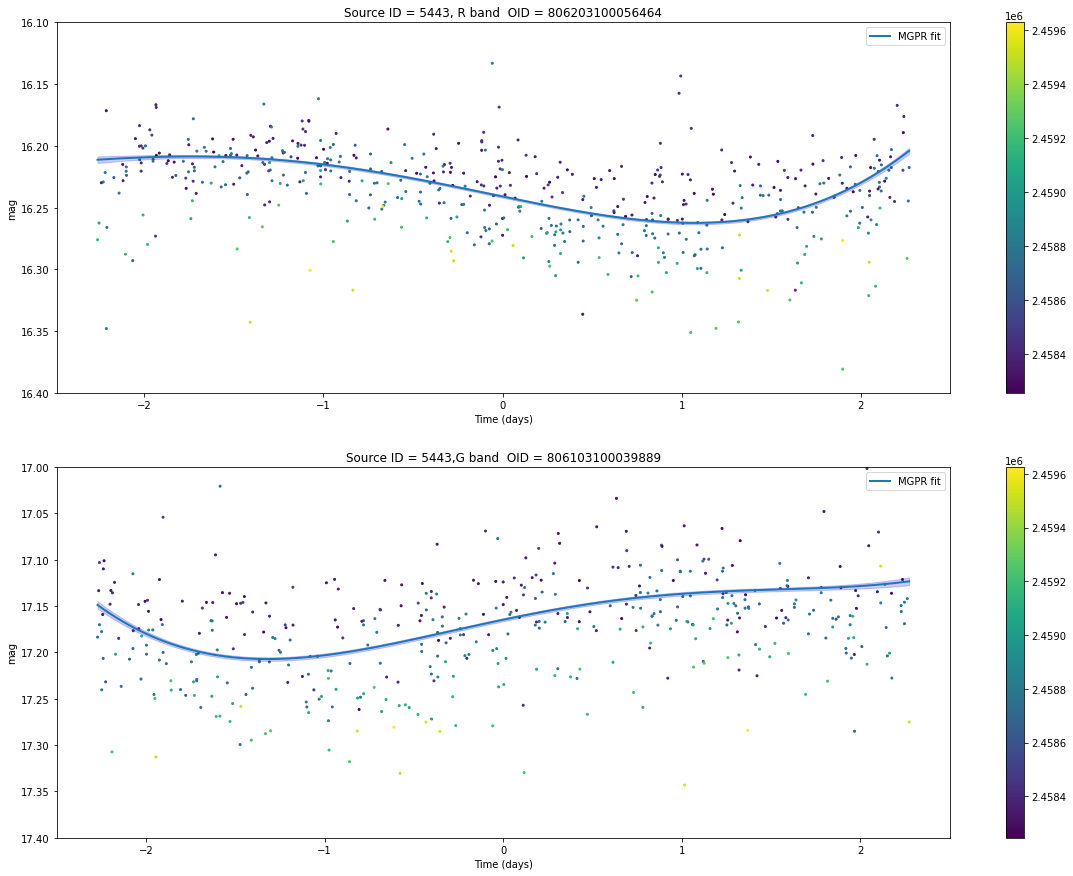

In [10]:
functions.MGPRfit(5443,force_period=4.553928366587967,ylim=[(16.4,16.1),(17.4,17.0)])

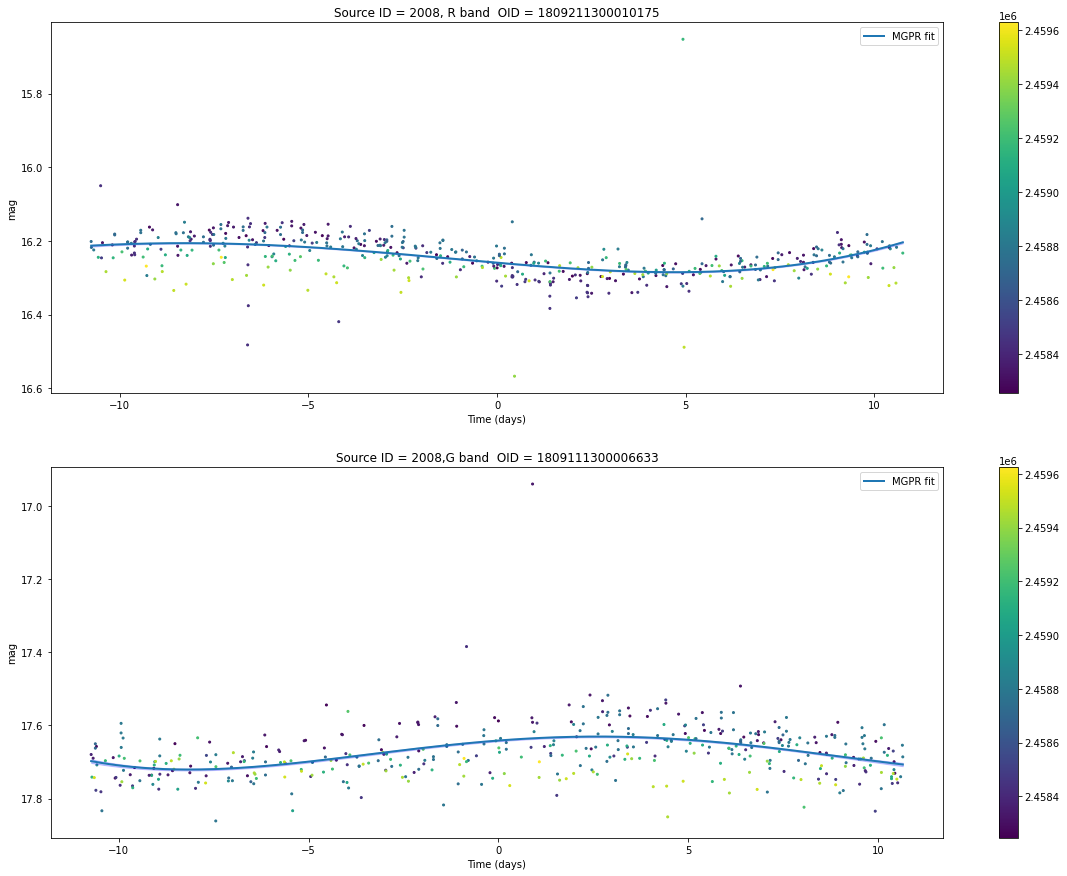

In [11]:
functions.MGPRfit(2008)

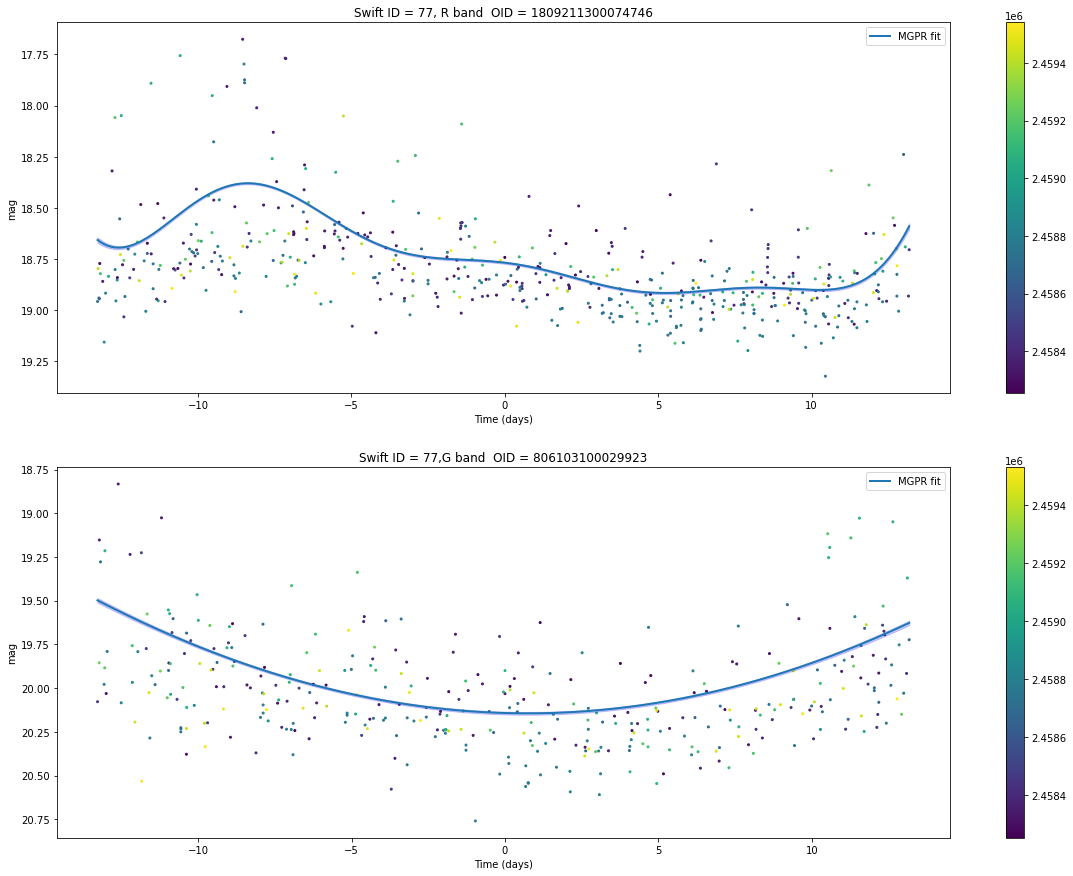

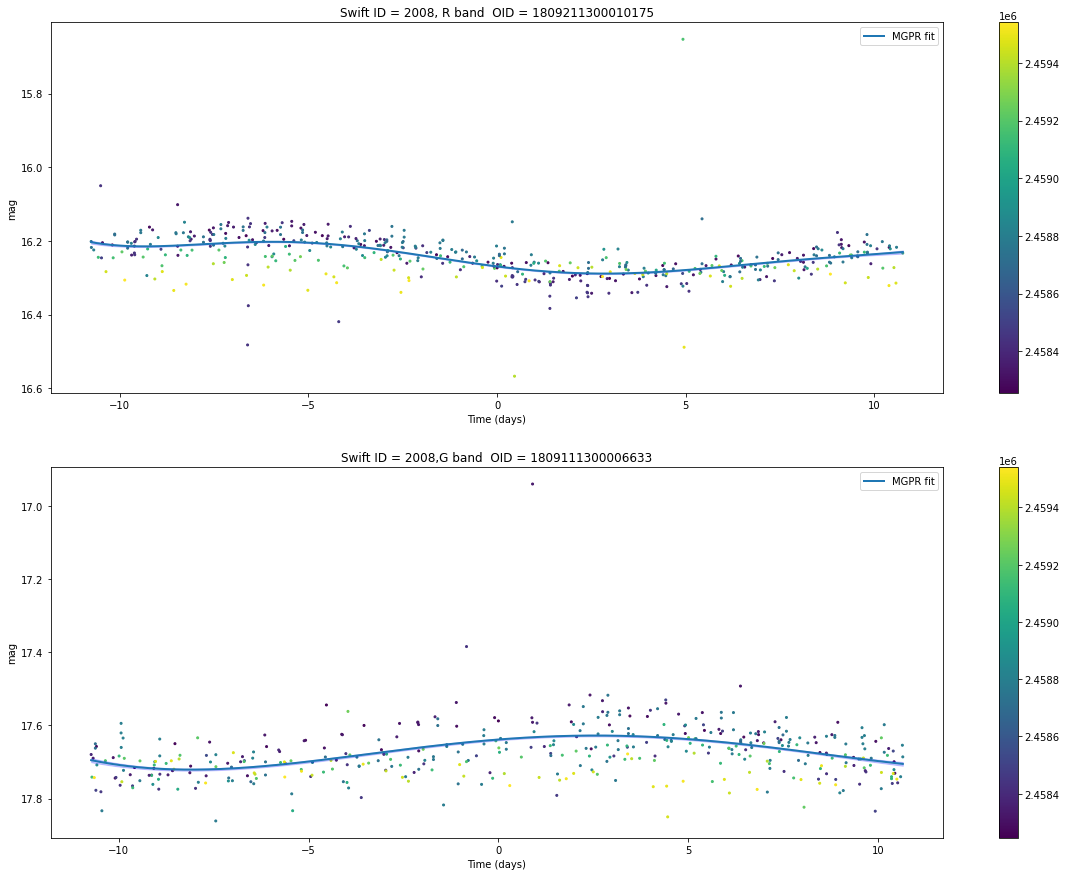

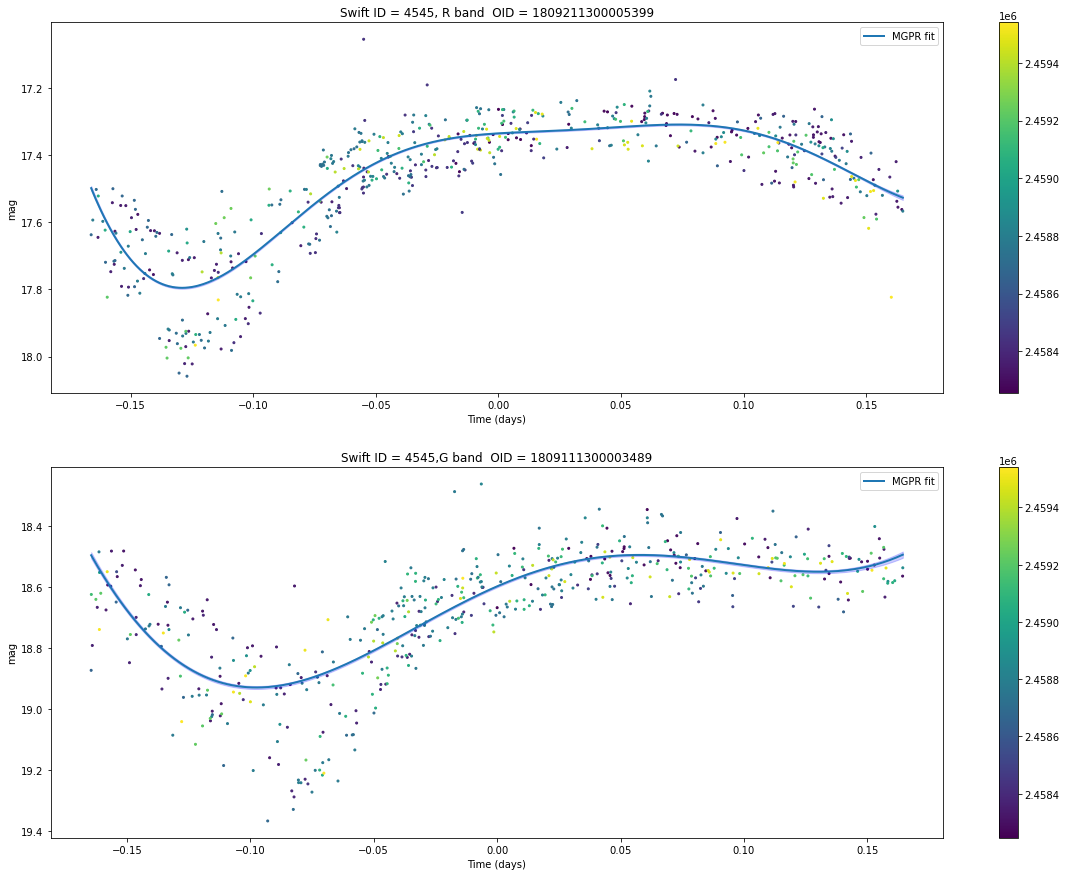

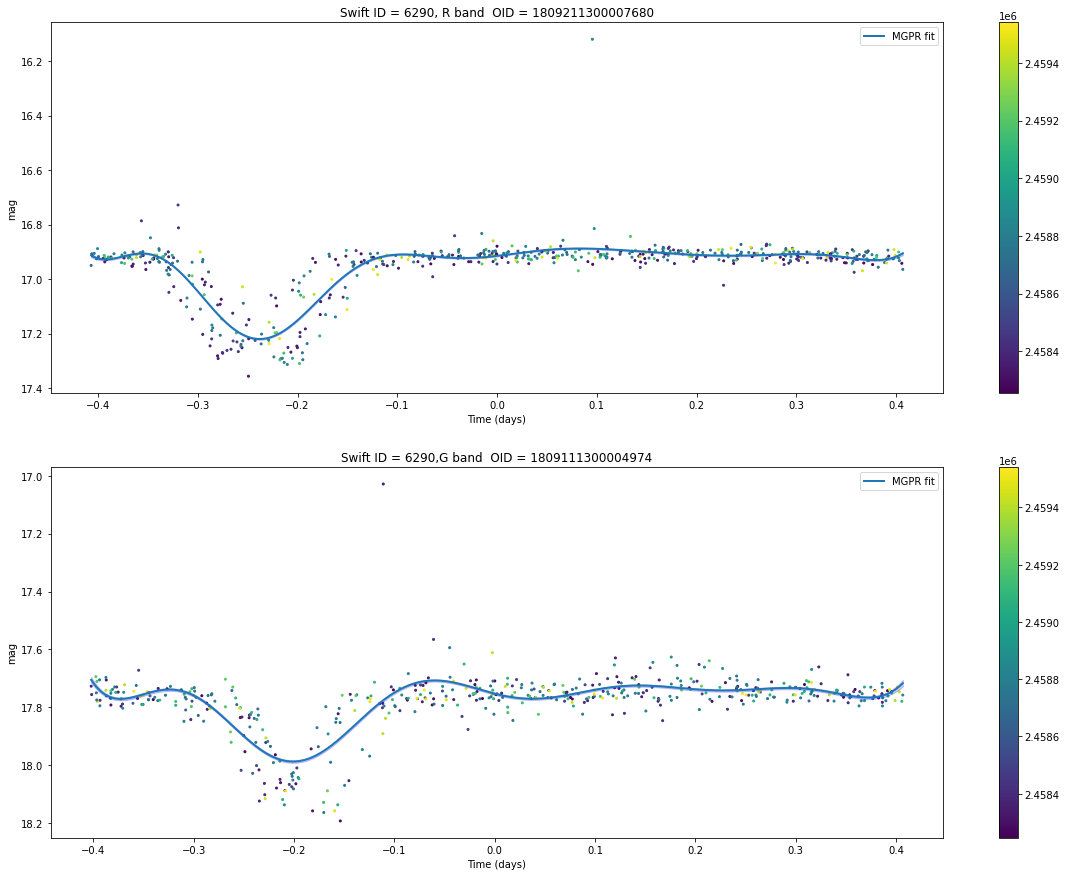

In [8]:
for row in cata[cata['variant in zg']&cata['variant in zr']]:
    functions.MGPRfit(row['SourceID'])

In [49]:
t_zr=QTable.read('t_zr_0418.ecsv')
t_zg=QTable.read('t_zg_0418.ecsv')
t_zr=t_zr[np.isnan(t_zr['LNP_SIG'])==False]
t_zg=t_zg[np.isnan(t_zg['LNP_SIG'])==False]


# select low LNP_SIG ones, (rule out popular periods in window function?)
def cut_LNP_SIG(t,period,LNP_SIG):
    #t=t[(t['period']<period[0])|(t['period']>period[1])]
    #t=t[(t['period']<period[2])|(t['period']>period[3])]
    #if len(period)>4:
        #t=t[(t['period']<period[4])|(t['period']>period[5])]
    t=t[t['LNP_SIG']<LNP_SIG]
    return t

# actually didnt do this period cut
period_cut_zr=(0.9970346508917344, 1.000477498206994)
period_cut_zg=(0.9969051801030641, 1.0158638399392756)

t_zr=cut_LNP_SIG(t_zr,period_cut_zr,0.0013169397670255696)
t_zg=cut_LNP_SIG(t_zg,period_cut_zg,0.00017317008113315558)

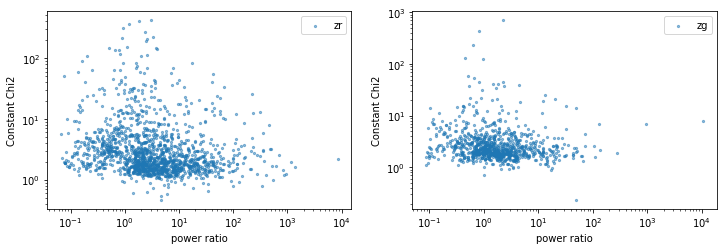

In [51]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.scatter(t_zr['power']/t_zr['power_c'],t_zr['CONST_CHI2'],s=5,label='zr',alpha=0.5)
plt.xlabel('power ratio')
plt.ylabel('Constant Chi2')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()
plt.subplot(222)
plt.scatter(t_zg['power']/t_zg['power_c'],t_zg['CONST_CHI2'],s=5,label='zg',alpha=0.5)
plt.xlabel('power ratio')
plt.ylabel('Constant Chi2')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

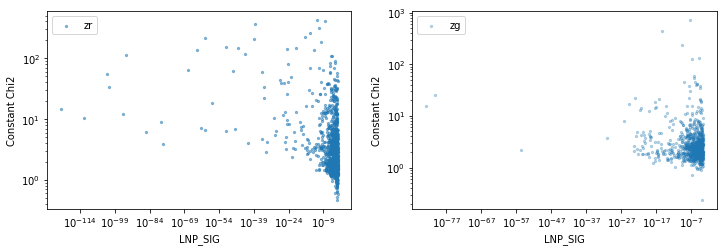

In [52]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.scatter(t_zr['LNP_SIG'],t_zr['CONST_CHI2'],s=5,label='zr',alpha=0.5)
plt.xlabel('LNP_SIG')
plt.ylabel('Constant Chi2')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()
plt.subplot(222)
plt.scatter(t_zg['LNP_SIG'],t_zg['CONST_CHI2'],s=5,label='zg',alpha=0.3)
plt.xlabel('LNP_SIG')
plt.ylabel('Constant Chi2')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

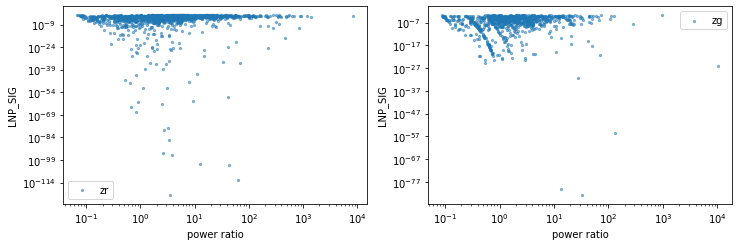

In [53]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.scatter(t_zr['power']/t_zr['power_c'],t_zr['LNP_SIG'],s=5,label='zr',alpha=0.5)
plt.xlabel('power ratio')
plt.ylabel('LNP_SIG')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()
plt.subplot(222)
plt.scatter(t_zg['power']/t_zg['power_c'],t_zg['LNP_SIG'],s=5,label='zg',alpha=0.5)
plt.xlabel('power ratio')
plt.ylabel('LNP_SIG')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

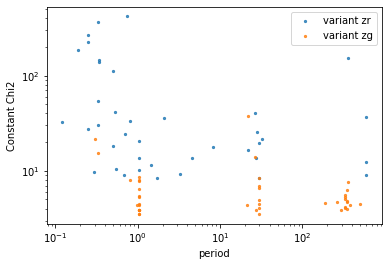

In [54]:
plt.scatter(obj_zr['period'],obj_zr['CONST_CHI2'],s=5,label='variant zr',alpha=0.8)
plt.scatter(obj_zg['period'],obj_zg['CONST_CHI2'],s=5,label='variant zg',alpha=0.8)
plt.xlabel('period')
plt.ylabel('Constant Chi2')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

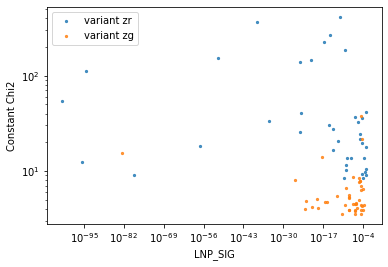

In [55]:
plt.scatter(obj_zr['LNP_SIG'],obj_zr['CONST_CHI2'],s=5,label='variant zr',alpha=0.8)
plt.scatter(obj_zg['LNP_SIG'],obj_zg['CONST_CHI2'],s=5,label='variant zg',alpha=0.8)
plt.xlabel('LNP_SIG')
plt.ylabel('Constant Chi2')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

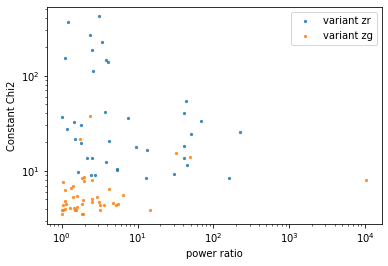

In [56]:
plt.scatter(obj_zr['power']/obj_zr['power_c'],obj_zr['CONST_CHI2'],s=5,label='variant zr',alpha=0.8)
plt.scatter(obj_zg['power']/obj_zg['power_c'],obj_zg['CONST_CHI2'],s=5,label='variant zg',alpha=0.8)
plt.xlabel('power ratio')
plt.ylabel('Constant Chi2')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

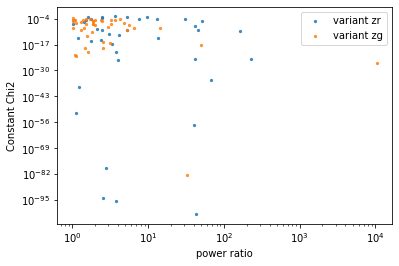

In [57]:
plt.scatter(obj_zr['power']/obj_zr['power_c'],obj_zr['LNP_SIG'],s=5,label='variant zr',alpha=0.8)
plt.scatter(obj_zg['power']/obj_zg['power_c'],obj_zg['LNP_SIG'],s=5,label='variant zg',alpha=0.8)
plt.xlabel('power ratio')
plt.ylabel('Constant Chi2')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

In [ ]:
# something happens in G

In [38]:
def combine(t_zr,t_zg,unique=np.array([np.nan])):
    zr=np.array(t_zr['SourceID'])
    zg=np.array(t_zg['SourceID'])
    if np.isnan(unique[0]):
        unique=np.unique(np.append(zg,zr))
    common=unique[(np.isin(unique,zr))&(np.isin(unique,zg))]
    t = QTable([common,np.full(len(common), np.nan),np.full(len(common), np.nan),np.empty(len(common),'S14'),np.empty(len(common),'S14'),np.full(len(common), np.nan),np.full(len(common), np.nan),np.full(len(common), np.nan),np.full(len(common), np.nan),np.full(len(common), np.nan),np.full(len(common), np.nan)]
               ,names=('SourceID', 'period_zr','period_zg','upsilon class_zr','upsilon class_zg','LNP_SIG_zr','LNP_SIG_zg','CONST_CHI2_zr','CONST_CHI2_zg','power_ratio_zr','power_ratio_zg'))
    
    for i,ID in enumerate(common):
        zr=t_zr[t_zr['SourceID']==ID]
        zr=zr[zr['numobs'].argmax()]
        zg=t_zg[t_zg['SourceID']==ID]
        zg=zg[zg['numobs'].argmax()]
        
        t[i]['period_zr']=zr['period']
        t[i]['period_zg']=zg['period']
        t[i]['upsilon class_zr']=zr['upsilon_class']
        t[i]['upsilon class_zg']=zg['upsilon_class']
        t[i]['LNP_SIG_zr']=zr['LNP_SIG']
        t[i]['LNP_SIG_zg']=zg['LNP_SIG']
        t[i]['CONST_CHI2_zr']=zr['CONST_CHI2']
        t[i]['CONST_CHI2_zg']=zg['CONST_CHI2']
        t[i]['power_ratio_zr']=zr['power']/zr['power_c']
        t[i]['power_ratio_zg']=zg['power']/zg['power_c']
           
    return t

In [59]:
t_zr=QTable.read('t_zr_0418.ecsv')
t_zg=QTable.read('t_zg_0418.ecsv')
t_zr=t_zr[np.isnan(t_zr['LNP_SIG'])==False]
t_zg=t_zg[np.isnan(t_zg['LNP_SIG'])==False]

In [66]:
t_zr[t_zr['CONST_CHI2']>100]

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,LNP_SIG,period,period_c,power,power_c,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
42,zr,806203100023517,5.0844829,59.3020474,244,82.00321960449219,117.11085794703207,1.764925400941318e-43,0.9971484977856219,0.9973052680316117,0.7648161566545373,0.9339426082602631,NonVar,0.51,1.0,0.04157537641950494
90,zr,806203100056957,5.0836327,59.3114535,900,525.0966796875,110.81225216581812,6.002845842879131e-95,0.4994384343050958,0.9973493234494499,0.6263888583536013,0.24530401407698715,LPV_Mira_AGB_C,0.28,0.0,1928.588663250004
834,zr,806203100043316,5.0215189,59.3240328,59,68.71305084228516,187.1539134059159,1.531315112664993e-10,0.1852931673206072,0.9973052680316117,0.801792209329557,0.3245950270575618,RRL_ab,0.26,1.0,0.9613688834806768
920,zr,806203100056984,5.0043896,59.3055805,92,99.12955474853516,263.71793191827135,1.2697871391022516e-15,0.25000020097450365,0.9973497006029647,0.7967586720966737,0.3380765853770599,DSCT,0.52,1.0,0.14623103460150613
1850,zr,1809211300054065,5.1628009,59.3338576,69,1319.7183837890625,101.26492260381386,0.3386903588146195,0.33691638934968066,0.9972164461363069,0.19067848843161556,0.40354011204421597,NonVar,0.48,1.0,0.09425311711373714
1891,zr,806203100056801,5.1640484,59.3340478,712,1791.3067626953125,108.46481686724252,1.2072819873786373e-06,384.61661844460883,0.9973493234494499,0.11577216146746633,0.5667550929808994,NonVar,0.5,1.0,0.9946305638215595
1903,zr,806203400030775,5.0344836,59.2510593,117,106.74398803710938,363.7043978974651,3.6884270713339245e-39,0.3327190793616673,0.9973615362352404,0.8639898539342133,0.7146624205410582,DSCT,0.5,1.0,0.16738727436276674
2032,zr,806203400030910,5.0916919,59.2457731,561,707.8837890625,205.74814035290774,1.586440227334809e-39,0.9988990338068926,0.9973493234494499,0.4758674421862835,0.1858369873408709,NonVar,0.36,0.0,1928.588663250004
2032,zr,1809211300055117,5.0915268,59.2456694,75,751.6947631835938,137.21870620135368,1.352404272848592e-13,472.31795980902666,0.9972164461363069,0.6255492874227808,0.7823159540183338,LPV_Mira_AGB_C,0.47,1.0,665.8511458499961


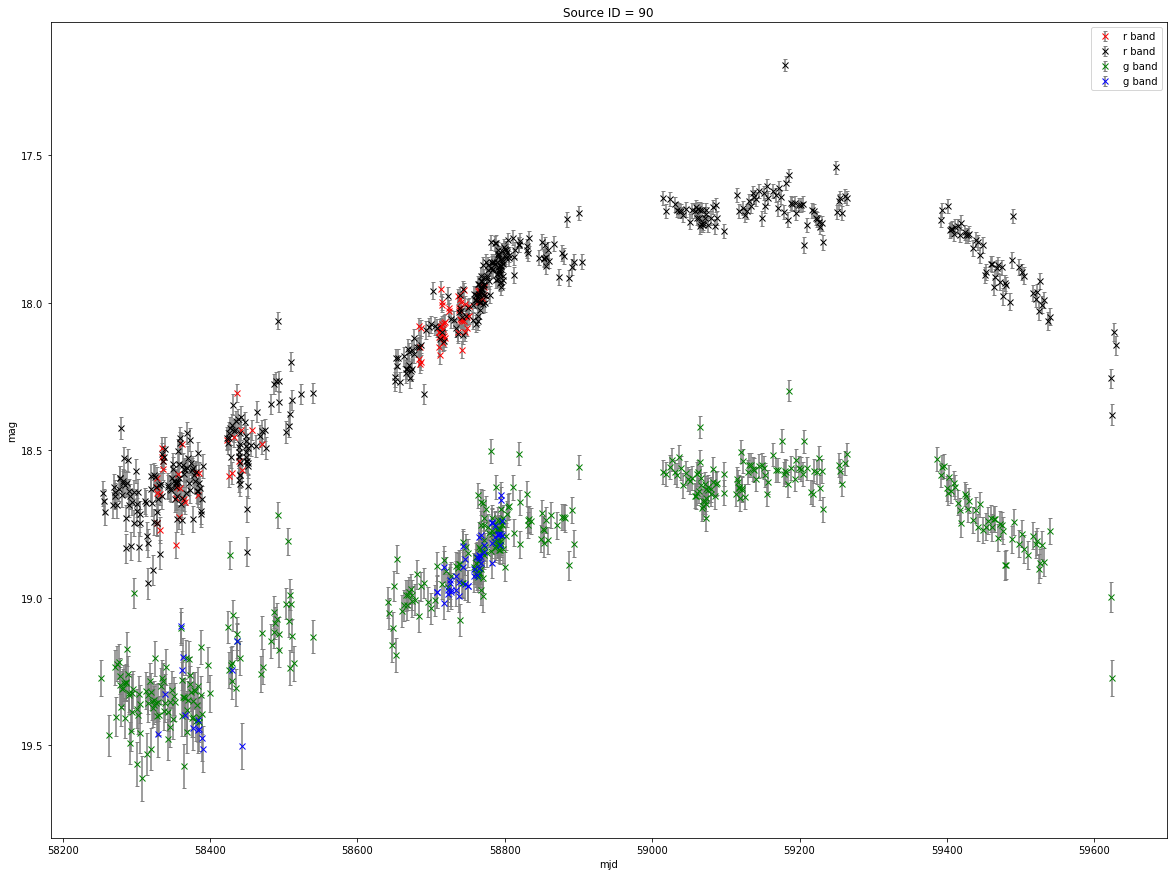

In [68]:
functions.draw_lightcurve(90)

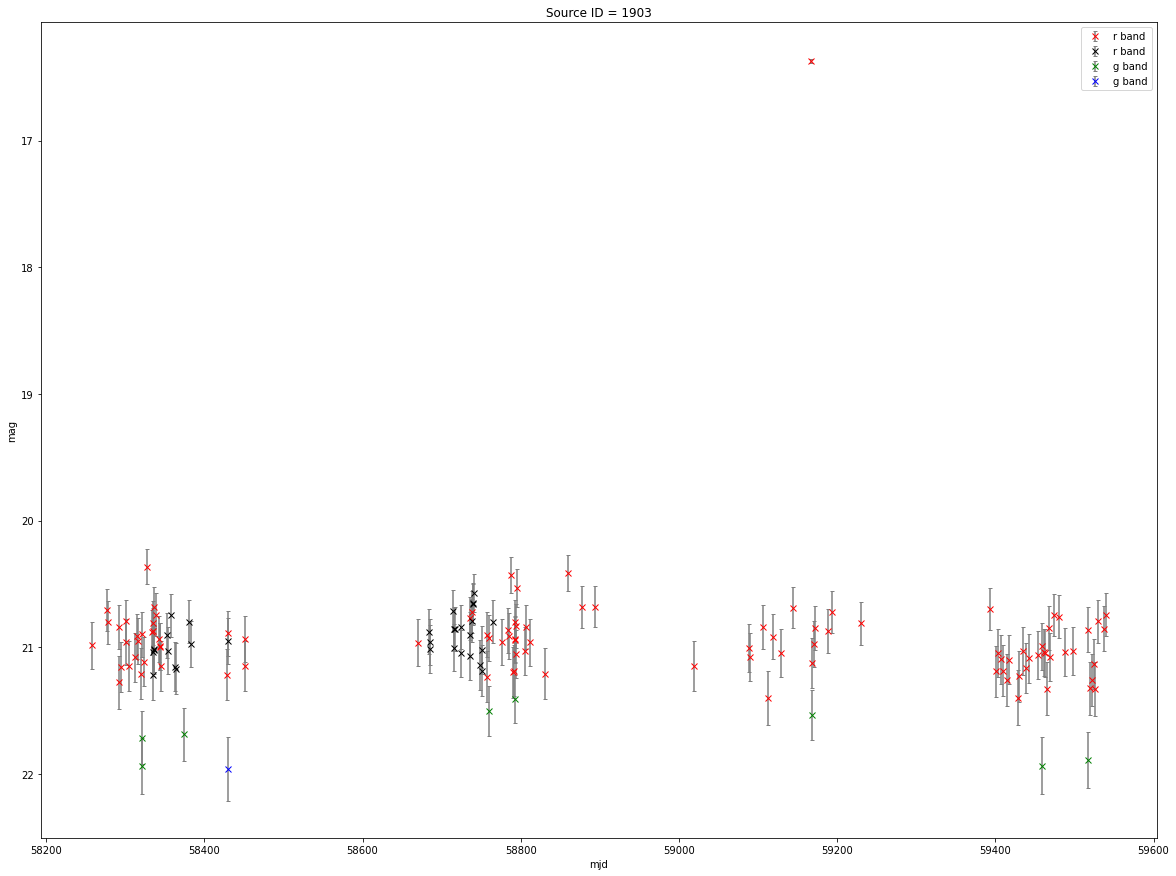

In [65]:
functions.draw_lightcurve(1903)

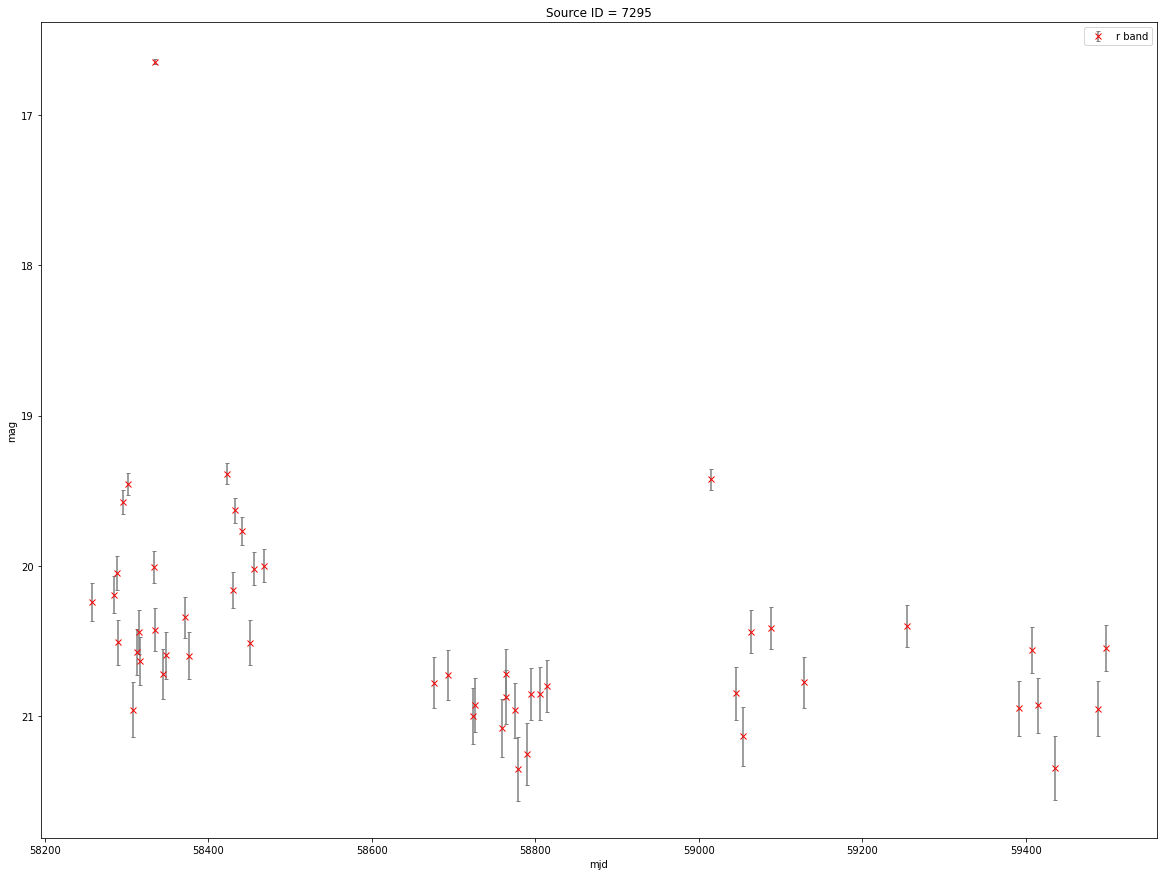

In [64]:
functions.draw_lightcurve(7295)

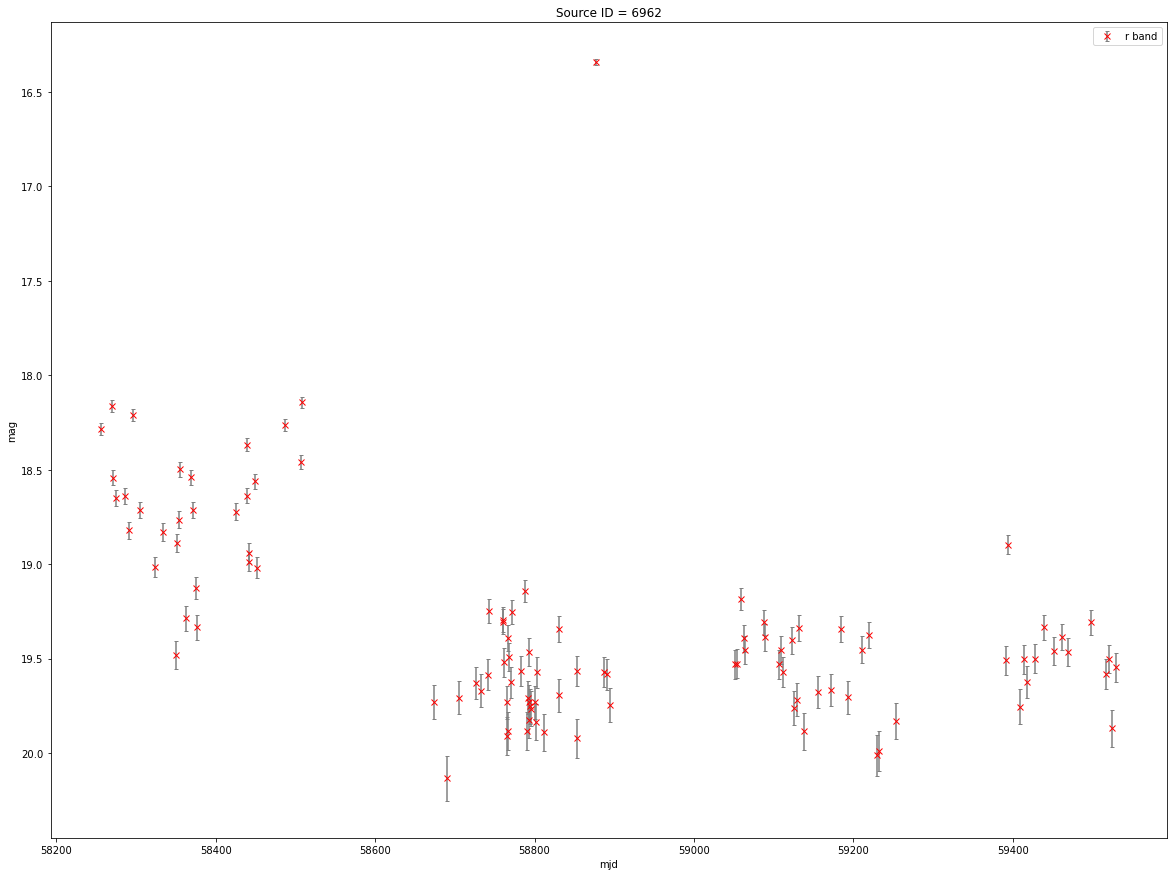

In [63]:
functions.draw_lightcurve(6962)

In [40]:
common_all=combine(t_zr,t_zg)
common_var=combine(t_zr,t_zg,unique=np.unique(np.append(np.array(obj_zr['SourceID']),np.array(obj_zg['SourceID']))))

In [41]:
common_var

SourceID,period_zr,period_zg,upsilon class_zr,upsilon class_zg,LNP_SIG_zr,LNP_SIG_zg,CONST_CHI2_zr,CONST_CHI2_zg,power_ratio_zr,power_ratio_zg
int32,float64,float64,bytes14,bytes14,float64,float64,float64,float64,float64,float64
73,0.49967309384852715,1.0322811463793122,DSCT,DSCT,0.000479414890782894,5.149112547141044e-08,4.209215842612668,8.611596891434157,1.8305012255696687,1.9778291422061975
77,26.59597181848844,26.57041565577648,CEPH_Other,CEPH_Other,5.847057797857361e-25,3.935053186145385e-18,40.2373047076145,13.899411195034224,41.20007029508097,49.265462800371715
90,0.4994384343050958,1.0005877015234323,LPV_Mira_AGB_C,NonVar,6.002845842879131e-95,6.50308944888019e-81,110.81225216581812,25.242491216755685,2.553520620975297,13.180397984240265
113,0.11900910767255984,382.1324629256383,NonVar,DSCT,0.006122809341387545,0.0001713371184101865,3.854371504154154,4.345429517934142,80.75373883411176,1.0299548980918525
114,32.30757695511111,0.10225239045595891,CEPH_Other,DSCT,1.2228950329205045e-05,0.01295216506638451,21.612575346683766,9.742340887056924,1.509193914725467,10.314781755608005
242,0.4995160488378665,0.9971252718653445,LPV_SRV_AGB_C,NonVar,5.518388785022263e-58,1.8507516580992872e-10,18.179304481554386,7.236786525692247,40.90544030681376,0.5079351290462238
301,0.31387503207680373,189.98460693916914,NonVar,NonVar,0.005144641628895164,5.104723637952057e-07,2.2479419135306005,4.61485567008685,193.7877511174284,4.768031991491748
708,0.1572879673580744,29.650582544156908,NonVar,CEPH_Other,0.013690578367255644,1.5310268344196832e-06,1.574255752164981,4.11152705438243,78.94466494118588,1.2949240062279108
764,0.6305580011930769,359.1820325198043,DSCT,DSCT,1.7957655280145015e-06,6.2496771043374685e-06,7.946839800236743,7.680776798838688,1.300002569028702,1.0367587965383642


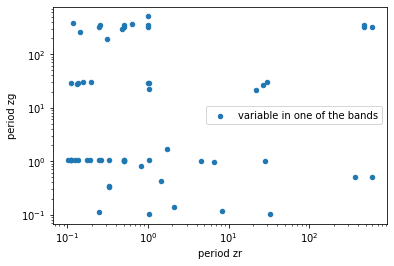

In [58]:
plt.scatter(common_var['period_zr'],common_var['period_zg'],s=20,label='variable in one of the bands')
plt.xlabel('period zr')
plt.ylabel('period zg')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

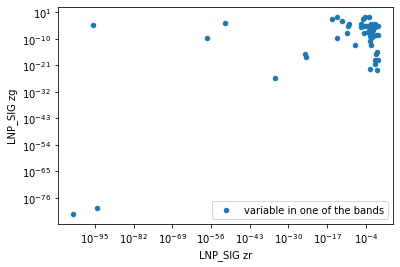

In [43]:
plt.scatter(common_var['LNP_SIG_zr'],common_var['LNP_SIG_zg'],s=20,label='variable in one of the bands')
plt.xlabel('LNP_SIG zr')
plt.ylabel('LNP_SIG zg')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

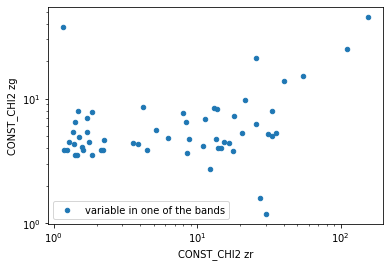

In [44]:
plt.scatter(common_var['CONST_CHI2_zr'],common_var['CONST_CHI2_zg'],s=20,label='variable in one of the bands')
plt.xlabel('CONST_CHI2 zr')
plt.ylabel('CONST_CHI2 zg')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

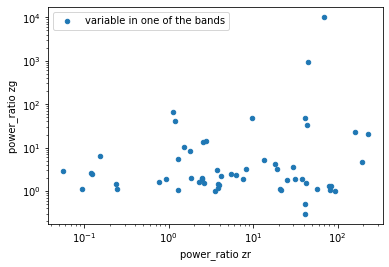

In [45]:
plt.scatter(common_var['power_ratio_zr'],common_var['power_ratio_zg'],s=20,label='variable in one of the bands')
plt.xlabel('power_ratio zr')
plt.ylabel('power_ratio zg')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

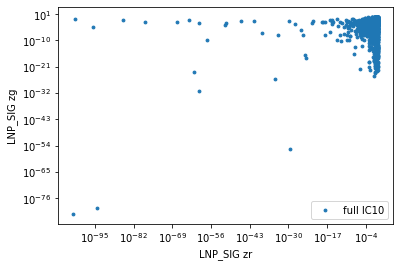

In [46]:
plt.scatter(common_all['LNP_SIG_zr'],common_all['LNP_SIG_zg'],s=8,label='full IC10')
plt.xlabel('LNP_SIG zr')
plt.ylabel('LNP_SIG zg')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

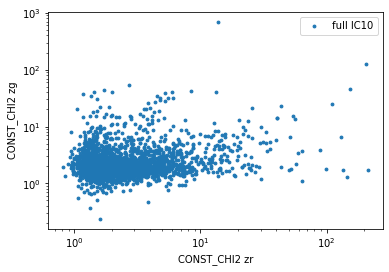

In [47]:
plt.scatter(common_all['CONST_CHI2_zr'],common_all['CONST_CHI2_zg'],s=8,label='full IC10')
plt.xlabel('CONST_CHI2 zr')
plt.ylabel('CONST_CHI2 zg')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

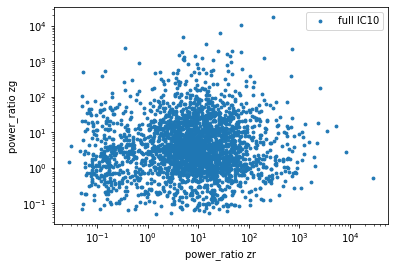

In [48]:
plt.scatter(common_all['power_ratio_zr'],common_all['power_ratio_zg'],s=8,label='full IC10')
plt.xlabel('power_ratio zr')
plt.ylabel('power_ratio zg')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.legend()

In [10]:
upsilon_zr=t_zr[t_zr['upsilon_class']!='NonVar']
upsilon_zg=t_zg[t_zg['upsilon_class']!='NonVar']
upsilon_zr=upsilon_zr[upsilon_zr['upsilon_flag']==0]
upsilon_zg=upsilon_zg[upsilon_zg['upsilon_flag']==0]

In [27]:
np.intersect1d(upsilon_zr['SourceID'],obj_zr['SourceID']).shape

(12,)

In [26]:
np.intersect1d(upsilon_zg['SourceID'],obj_zg['SourceID']).shape

(13,)

In [35]:
np.intersect1d(upsilon_zr['SourceID'],upsilon_zg['SourceID'])

array([  77,   90, 1299, 2008, 2818, 3546, 6290])

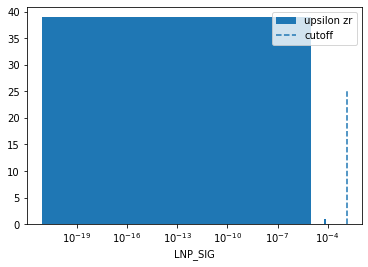

In [49]:
hist(upsilon_zr['LNP_SIG'],bins='scott',label='upsilon zr');
plt.vlines(0.0013169397670255696,0,25,ls='--',label='cutoff')
plt.xlabel('LNP_SIG')
plt.legend()
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")

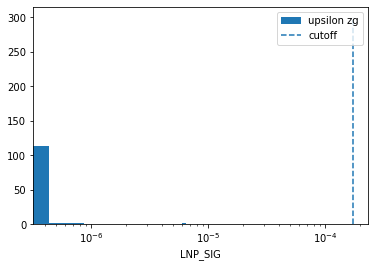

In [50]:
hist(upsilon_zg['LNP_SIG'],bins='scott',label='upsilon zg');
plt.vlines(0.00017317008113315558,0,300,ls='--',label='cutoff')
plt.xlabel('LNP_SIG')
plt.legend()
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")

In [39]:
upsilon_zr['LNP_SIG'].max(),upsilon_zg['LNP_SIG'].max()

(6.596765897327932e-05, 6.433869724661677e-06)

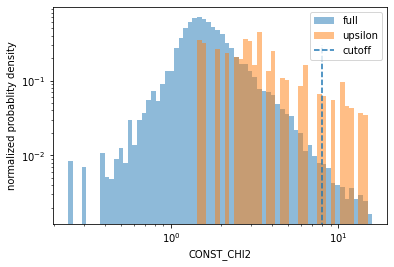

In [51]:
tt_zr=t_zr[(t_zr['CONST_CHI2']>0)&(t_zr['CONST_CHI2']<16)]
_, bins = np.histogram(np.log10(tt_zr['CONST_CHI2']), bins='auto')
plt.hist(tt_zr['CONST_CHI2'], bins=10**bins,density=1,alpha=0.5,label='full');
plt.hist(upsilon_zr['CONST_CHI2'], bins=10**bins,density=1,alpha=0.5,label='upsilon');
plt.vlines(8,0,0.3,ls='--',label='cutoff')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.xlabel('CONST_CHI2')
plt.ylabel('normalized probablity density')
plt.legend()

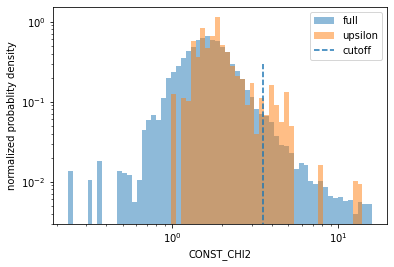

In [52]:
tt_zg=t_zg[(t_zg['CONST_CHI2']>0)&(t_zg['CONST_CHI2']<16)]
_, bins = np.histogram(np.log10(tt_zg['CONST_CHI2']), bins='auto')
plt.hist(tt_zg['CONST_CHI2'], bins=10**bins,density=1,alpha=0.5,label='full');
plt.hist(upsilon_zg['CONST_CHI2'], bins=10**bins,density=1,alpha=0.5,label='upsilon');
plt.vlines(3.5,0,0.3,ls='--',label='cutoff')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.xlabel('CONST_CHI2')
plt.ylabel('normalized probablity density')
plt.legend()

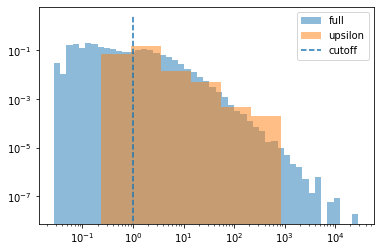

In [55]:
obj=t_zr['power']/t_zr['power_c']
plt.hist(obj, bins=np.logspace(np.log10(obj.min()),np.log10(obj.max()), 50),density=1,alpha=0.5,label='full')
obj=upsilon_zr['power']/upsilon_zr['power_c']
plt.hist(obj,bins=np.logspace(np.log10(obj.min()),np.log10(obj.max()), 7),density=1,alpha=0.5,label='upsilon')
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.vlines(1,0,2.5,ls='--',label='cutoff')
plt.legend()

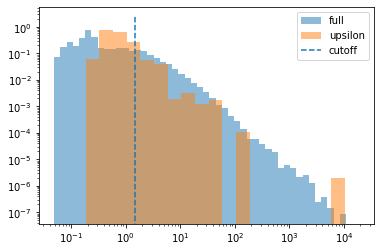

In [56]:
obj=t_zg['power']/t_zg['power_c']
plt.hist(obj, bins=np.logspace(np.log10(obj.min()),np.log10(obj.max()), 50),density=1,alpha=0.5,label='full')
obj=upsilon_zg['power']/upsilon_zg['power_c']
plt.hist(obj,bins=np.logspace(np.log10(obj.min()),np.log10(obj.max()), 20),density=1,alpha=0.5,label='upsilon')
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.vlines(1.5,0,2.5,ls='--',label='cutoff')
plt.legend()

In [ ]:
# smaller region - 450"/2
# look at individual sources